# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import warnings

import imageio  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append("../modules")
import plot_clustering as plt_cp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import smoothing_particles as sp  # type: ignore
import track_particles as tp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

ordering = True
video_name = "4n_0m_4f_230330_1"
n_particles = int(video_name[0])
save_figures = True
x_bounds = [0, 1080]
y_bounds = [140, 1830]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Load tracked data

In [3]:
df_tracked = pd.read_csv(
    "{}/clustered_{}.csv".format(output_path, video_name), low_memory=False
)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,174.127665,195.135174,181.819422,193.256795,0.0,254.000000,134.000000,0.478431,244.000000,184.000000,1.144628,8256.0,245.783258,89.013272,0.932115,4,NaN,NaN,NaN,NaN,False,False,False
1,1,0,751.374107,245.176755,735.602316,251.633456,NaN,751.374107,245.176755,NaN,751.374107,245.176755,-1.381955,9516.0,227.988192,89.631381,0.919478,4,NaN,NaN,NaN,NaN,False,False,False
2,2,0,1496.073540,953.368453,1488.319254,955.058852,NaN,1496.073540,953.368453,NaN,1496.073540,953.368453,-1.500249,6663.0,152.773965,71.797058,0.882690,4,NaN,NaN,NaN,NaN,False,False,False
3,3,0,1249.070796,972.525014,1247.666709,970.220410,NaN,1249.070796,972.525014,NaN,1249.070796,972.525014,1.055800,5537.0,138.705979,84.502996,0.792998,4,NaN,NaN,NaN,NaN,False,False,False


In [4]:
df_tracked.tail(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
33600,0,25200,136.689704,108.601316,152.108192,114.687567,NaN,97.189717,110.958819,NaN,136.689704,108.601316,1.230642,2127.0,140.256917,32.504285,0.972776,4,3.0,0.000000,0.000000,0.0,False,False,False
33601,1,25200,116.425981,247.884706,131.531767,263.475779,NaN,115.908712,244.065711,NaN,116.521052,250.195654,-0.053286,19437.0,409.762183,231.031877,0.825898,4,3.0,0.031311,0.022233,0.0,False,False,False
33602,2,25200,1329.224892,545.894952,1329.105383,545.605014,NaN,1329.224892,545.894952,NaN,1329.224892,545.894952,-1.481582,622.0,115.580491,25.135354,0.976067,4,3.0,0.000000,0.000000,0.0,False,False,False
33603,3,25200,1556.536805,913.253759,1554.837238,902.773487,NaN,1579.558554,800.068479,NaN,1557.152304,884.834104,-0.393002,6999.0,170.193447,62.253087,0.930702,4,3.0,0.031909,-0.074679,0.0,False,False,False


## Swapping mixed IDs

In [5]:
omega_threshold = 20 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 83  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

from importlib import reload
reload(sp)

arg_list = [
    # VIDEO 1
    [0    , 10000, velocity_threshold, omega_threshold, True],
    [10000, 20000, velocity_threshold, omega_threshold, True],
    [20000, 25203, velocity_threshold, omega_threshold, True]#,
    # [30000, 40000, velocity_threshold, omega_threshold, True],
    # [40000, 50000, velocity_threshold, omega_threshold, True],
    # [50000, 60000, velocity_threshold, omega_threshold, True],
    # [60000, 70000, velocity_threshold, omega_threshold, True],
    # [70000, 80000, velocity_threshold, omega_threshold, True],
    # [80000, 90000, velocity_threshold, omega_threshold, True],
    # [90000, 100000, velocity_threshold, omega_threshold, True],
    # [100000, 108000, velocity_threshold, omega_threshold, True],
    # [110000, 120000, velocity_threshold, omega_threshold, True],
    # [120000, 130000, velocity_threshold, omega_threshold, True],
    # [130000, 140000, velocity_threshold, omega_threshold, True],
    # [140000, 150000, velocity_threshold, omega_threshold, True],
    # [150000, 162000, velocity_threshold, omega_threshold, True]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 83 
	- Angle: 20.0 



100%|█████████████████████████| 4/4 [00:30<00:00,  7.69s/it]


Time: 30000 Chunks 2 Allowed time 30000 Permutation [0 1 2]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_10000,0,0,1614.560252,163.869588,1609.085819,163.174150,NaN,1614.560252,163.869588,NaN,1614.560252,163.869588,0.156844,0.156844,13626.0,241.851958,84.807675,0.936503,3,NaN,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_10000,1,1,254.328536,124.227237,256.354912,125.568024,NaN,254.328536,124.227237,NaN,254.328536,124.227237,-1.447997,-1.447997,12784.0,246.153150,99.103036,0.915373,3,NaN,NaN,NaN,NaN,False,False,False
2,True,0,chunk_00000_10000,2,2,1659.513413,755.552458,1657.928134,766.742186,0.0,1646.000000,649.000000,0.454902,1672.000000,660.000000,0.003155,0.003155,10475.0,260.333761,66.498809,0.966826,3,NaN,NaN,NaN,NaN,False,False,False
3,True,3,chunk_00000_10000,0,0,1615.054822,164.077816,1609.966921,163.569071,NaN,1615.054822,164.077816,NaN,1615.054822,164.077816,0.160556,0.160556,13699.0,241.461181,85.766379,0.934791,3,3.0,0.164856,0.069409,0.001237,False,False,False
4,True,3,chunk_00000_10000,1,1,254.276336,124.242846,256.316775,125.604954,NaN,254.276336,124.242846,NaN,254.276336,124.242846,1.447775,-1.447775,12720.0,246.323240,99.027279,0.915630,3,3.0,-0.017400,0.005203,-0.000074,False,False,True
5,True,3,chunk_00000_10000,2,2,1659.526235,755.583110,1657.997081,766.826054,0.0,1645.000000,649.000000,0.439216,1662.000000,662.000000,0.003634,0.003634,10444.0,260.860384,66.585938,0.966874,3,3.0,0.004274,0.010217,0.000160,False,False,False
6,True,6,chunk_00000_10000,0,0,1614.695442,163.770764,1609.261199,163.057264,NaN,1614.695442,163.770764,NaN,1614.695442,163.770764,0.157797,0.157797,13449.0,241.752764,84.251354,0.937308,3,3.0,-0.119793,-0.102351,-0.000920,False,False,False
7,True,6,chunk_00000_10000,1,1,254.400443,124.210347,256.468842,125.575936,NaN,254.400443,124.210347,NaN,254.400443,124.210347,1.448461,-1.448461,12641.0,246.001005,99.049320,0.915359,3,3.0,0.041369,-0.010833,0.000229,False,False,False


In [6]:
df_final.tail(5)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
35965,True,35994,chunk_30000_36000,1,1,1633.944195,524.048642,1632.194873,531.529619,NaN,1633.944195,524.048642,NaN,1633.944195,524.048642,0.096278,0.096278,12006.0,238.057693,73.433302,0.951235,3,3.0,-0.014209,-0.002861,-0.000335,False,False,False
35966,True,35994,chunk_30000_36000,2,2,1651.247651,790.092208,1644.453831,782.547693,0.0,1595.000000,685.000000,0.494118,1598.000000,693.000000,0.526148,-0.526148,10216.0,213.516898,74.208143,0.937661,3,3.0,-0.018114,-0.045817,-0.000251,False,False,False
35967,True,35997,chunk_30000_36000,0,0,479.683824,143.815833,484.251796,143.147939,0.0,452.000000,100.000000,0.666667,436.000000,185.000000,-1.443200,-1.443200,14552.0,249.966339,88.948689,0.934546,3,3.0,-0.000142,-0.003722,0.000054,False,False,False
35968,True,35997,chunk_30000_36000,1,1,1633.956718,524.037195,1632.221267,531.500816,NaN,1633.956718,524.037195,NaN,1633.956718,524.037195,0.096706,0.096706,11991.0,237.931562,73.392394,0.951237,3,3.0,0.004174,-0.003816,0.000143,False,False,False
35969,True,35997,chunk_30000_36000,2,2,1651.230807,790.106873,1644.416861,782.569994,0.0,1595.000000,685.000000,0.494118,1599.000000,693.000000,0.526500,-0.526500,10199.0,213.468536,74.148232,0.937736,3,3.0,-0.005615,0.004888,0.000117,False,False,False


## Interpolation over not allowed frames

In [7]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:, "permuted_id"] == df_full["permuted_id"].unique()[id_]
        df_full[mask] = df_full[mask].interpolate(method="linear")

In [8]:
if ordering:
    cols = [
        "id",
        "permuted_id",
        "time",
        "position_x",
        "position_y",
        "weighted_x",
        "weighted_y",
        "darkest_v",
        "darkest_x",
        "darkest_y",
        "lightest_v",
        "lightest_x",
        "lightest_y",
        "orientation",
        "corrected_orientation",
        "area",
        "axis_major",
        "axis_minor",
        "eccentricity",
    ]
    df_temp = df_full[cols]
    df_temp.to_csv(
        "{}/interpolated_{}.csv".format(output_path, video_name), index=False
    )
    df_temp

Thresholds:
	- Velocity: 14.454144890718903 
	- Angle: 4.052008491427094 



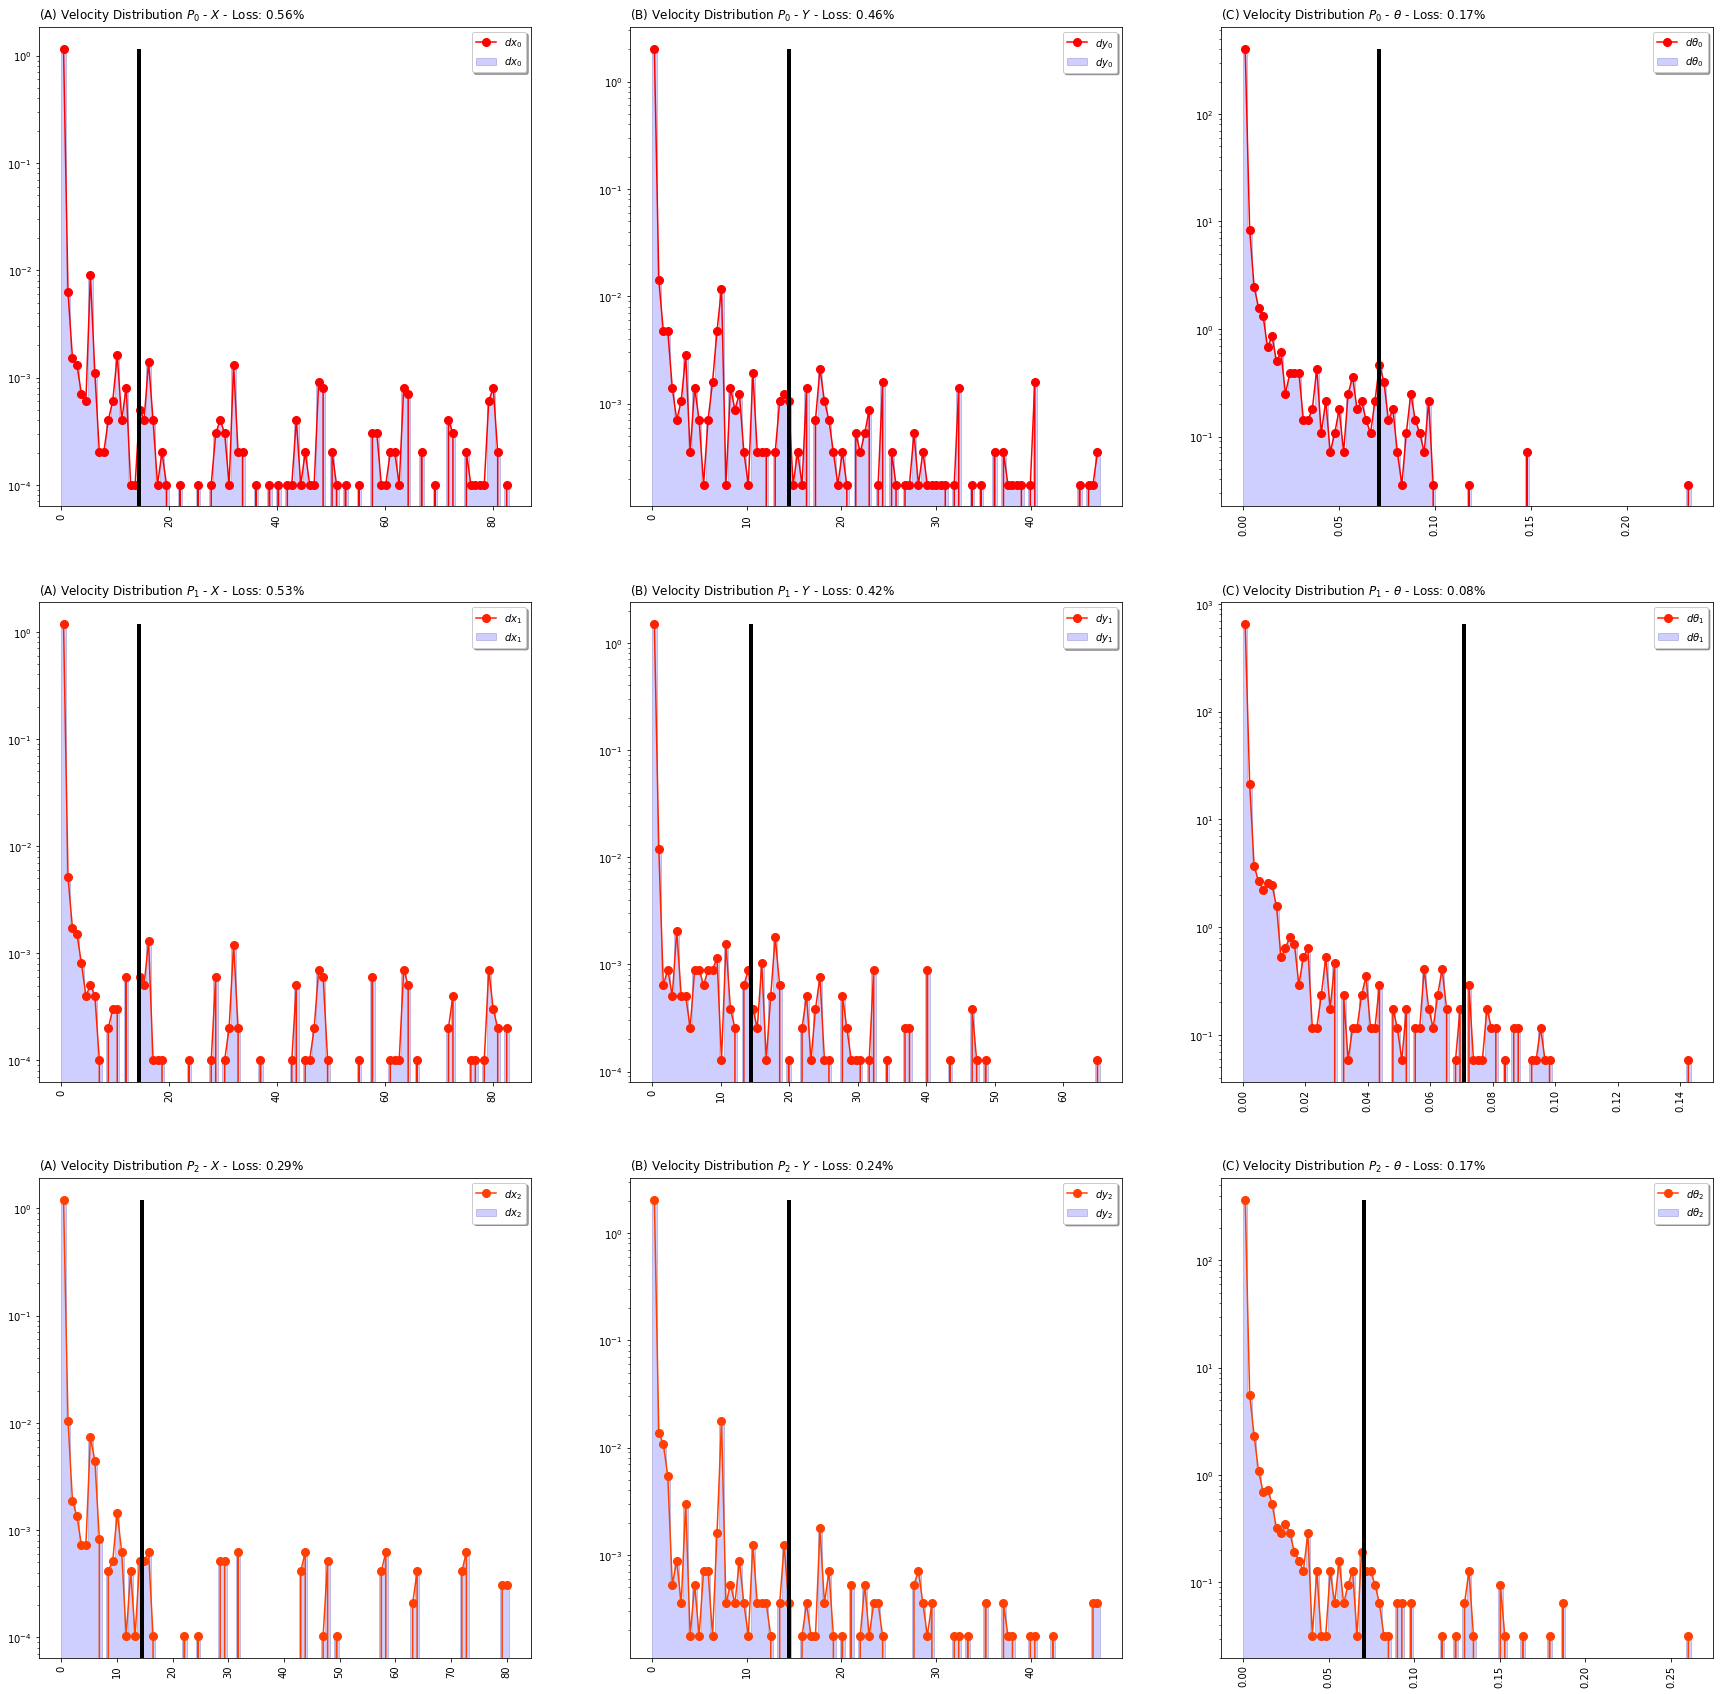

In [9]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = (
        df_full["velocity_orientation"].abs().quantile(0.9965)
    )  # Angular velocity per frame
    velocity_threshold = (
        df_full["velocity_x"].abs().quantile(0.9901)
    )  # Velocity per frame limited with half average size of particle
    print(
        "Thresholds:\n\t- Velocity:",
        velocity_threshold,
        "\n\t- Angle:",
        omega_threshold * 180 / np.pi,
        "\n",
    )

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend,
    )

Original


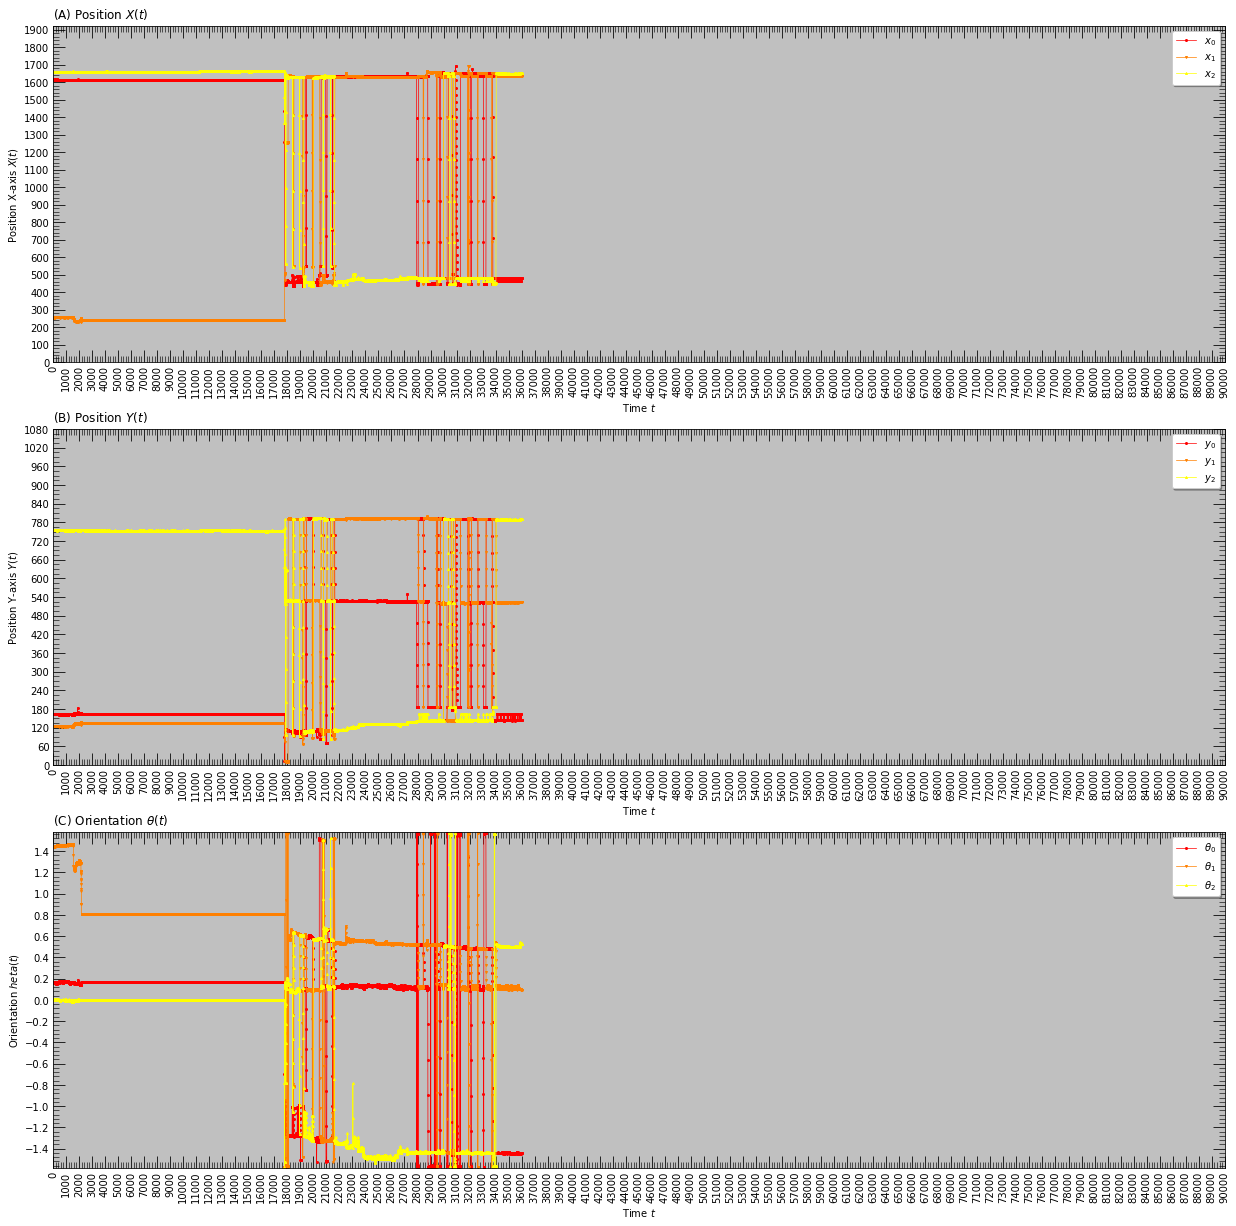

Corrected Orientation


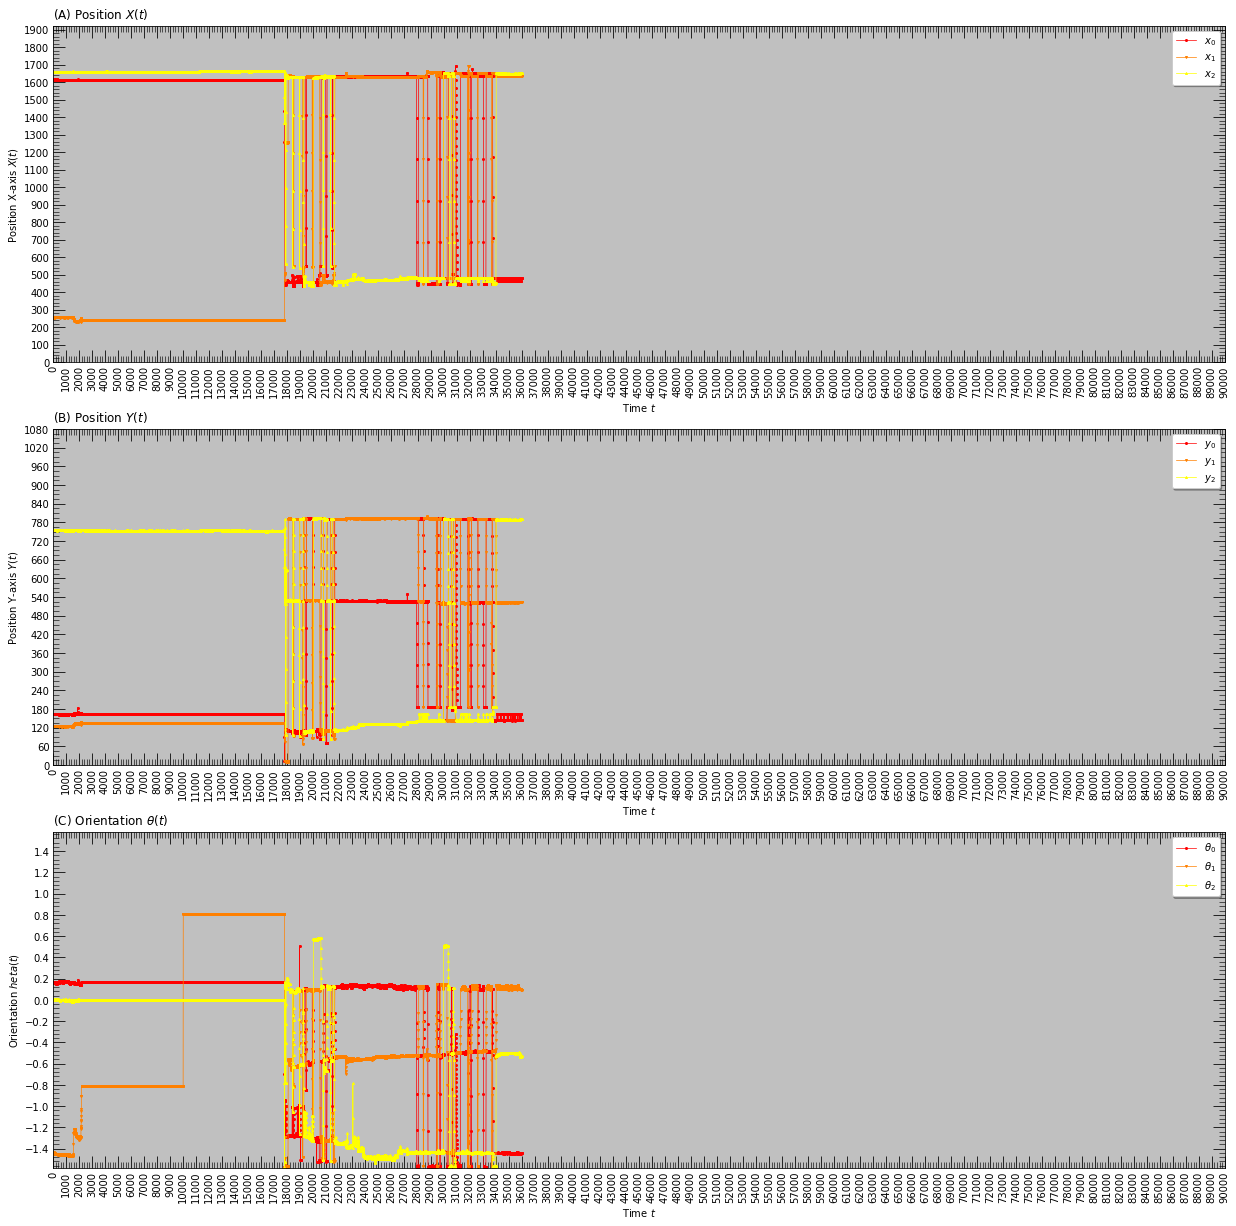

In [10]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf = 0, 90000  # 22200, 24300
    t0_, tf_ = 0, 90000  # 22200, 24300
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1920], [0, 1080], [-1.58, 1.58]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = (
        df_full["velocity_x"].abs().quantile(0.9701)
    )  # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[
            (
                (df_smooth["velocity_x"] <= velocity_threshold)
                & (df_smooth["velocity_y"] <= velocity_threshold)
            )
        ],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend,
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[
            (
                (df_smooth["velocity_x"] <= velocity_threshold)
                & (df_smooth["velocity_y"] <= velocity_threshold)
            )
        ],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend,
    )